# Import Block

In [1]:
! pip install geopandas pandas sqlalchemy psycopg2-binary openpyxl geoalchemy2 python-dotenv

/bin/bash: /media/mutakabbir/HDD_2TB_02/Forest_Fire/.venv/bin/pip: /media/mutakabbir/HDD_2TB_01/Forest_Fire/.venv/bin/python: bad interpreter: No such file or directory


In [2]:
from sqlalchemy import create_engine
import pandas as pd
import geopandas as gpd

import os
from dotenv import load_dotenv

# Global Variables

In [3]:
PATH_TO_DOT_ENV = "../.env"

DATABASE_TYPE = "postgresql"
DATABASE_HOST = "localhost"

MLFLOW_HOST = "localhost"

FIRE_SUBDIVISION_TABLE = "F_s"
SUBDIVISION_TABLE_NAME = "S"

MIN_YEAR = 1998
MAX_YEAR = 2022

In [4]:
load_dotenv(PATH_TO_DOT_ENV)

DATABASE_NAME = os.environ.get("DATABASE_NAME")
POSTGRES_USER = os.environ.get("POSTGRES_USER")
POSTGRES_PASSWORD = os.environ.get("POSTGRES_PASSWORD")
POSTGRES_HOST_PORT = os.environ.get("POSTGRES_HOST_PORT")
POSTGRES_CONTAINER_PORT = os.environ.get("POSTGRES_CONTAINER_PORT")

In [5]:
engine = create_engine(f"{DATABASE_TYPE}://{POSTGRES_USER}:{POSTGRES_PASSWORD}@{DATABASE_HOST}:{POSTGRES_HOST_PORT}/{DATABASE_NAME}")

# Preprocess Subdivisions

In [6]:
# extract clustter fire dataset
cluster_count_threshold = 0

query_fire_count_by_subdivision = f"""
select 
    division_id, 
    count(*) 
from 
    "{FIRE_SUBDIVISION_TABLE}" f 
where 
    f.start_date > '{MIN_YEAR}-01-01' and 
    f.start_date < '{MAX_YEAR}-01-01' and 
    cause = 'L' 
group by 
    f.division_id 
order by 
    f.division_id
"""
fire_count_df = pd.read_sql(query_fire_count_by_subdivision, con=engine, index_col='division_id')
fire_count_df = fire_count_df[fire_count_df['count'] > cluster_count_threshold]
fire_count_df.head()

,count
division_id,
0,787
1,2
2,1
4,7
5,671


In [7]:
# read divisions
query_subdivisions = f"""
select * 
from "{SUBDIVISION_TABLE_NAME}" s
"""
subdivion_df = gpd.read_postgis(query_subdivisions, con=engine, geom_col='geometry', index_col='cid', crs="EPSG:4326")
subdivion_df

,geometry
cid,
0,"MULTIPOLYGON (((-139.53267 69.53197, -139.5336..."
1,"MULTIPOLYGON (((-59.17563 47.55863, -59.17579 ..."
2,"MULTIPOLYGON (((-112.70518 67.67319, -112.7050..."
3,"MULTIPOLYGON (((-82.52584 42.47577, -82.52580 ..."
4,"POLYGON ((-112.31319 55.39631, -112.31267 55.3..."
...,...
62,"POLYGON ((-121.20810 50.56893, -121.20824 50.5..."
63,"POLYGON ((-118.79457 54.58827, -118.74824 54.5..."
64,"MULTIPOLYGON (((-121.00702 49.65631, -121.0066..."


In [8]:

# add numer of fire record count for each division
subdivion_df = subdivion_df.join(fire_count_df)
subdivion_df['div_id'] = subdivion_df.index

In [9]:
subdivion_df['area'] = subdivion_df.to_crs("EPSG:3857").area # convert to m^2
subdivion_df['area'] = subdivion_df['area'] / 100000 # convert to hectares
subdivion_df

,geometry,count,div_id,area
cid,,,,
0,"MULTIPOLYGON (((-139.53267 69.53197, -139.5336...",787.0,0,2.468307e+07
1,"MULTIPOLYGON (((-59.17563 47.55863, -59.17579 ...",2.0,1,1.970090e+06
2,"MULTIPOLYGON (((-112.70518 67.67319, -112.7050...",1.0,2,2.280980e+08
3,"MULTIPOLYGON (((-82.52584 42.47577, -82.52580 ...",NaN,3,5.043256e+05
4,"POLYGON ((-112.31319 55.39631, -112.31267 55.3...",7.0,4,9.525598e+05
...,...,...,...,...
62,"POLYGON ((-121.20810 50.56893, -121.20824 50.5...",229.0,62,8.502022e+05
63,"POLYGON ((-118.79457 54.58827, -118.74824 54.5...",132.0,63,2.183030e+06
64,"MULTIPOLYGON (((-121.00702 49.65631, -121.0066...",99.0,64,6.956076e+05


/tmp/ipykernel_206822/3362685133.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(subdivion_df.centroid.x, subdivion_df.centroid.y, subdivion_df['count']):


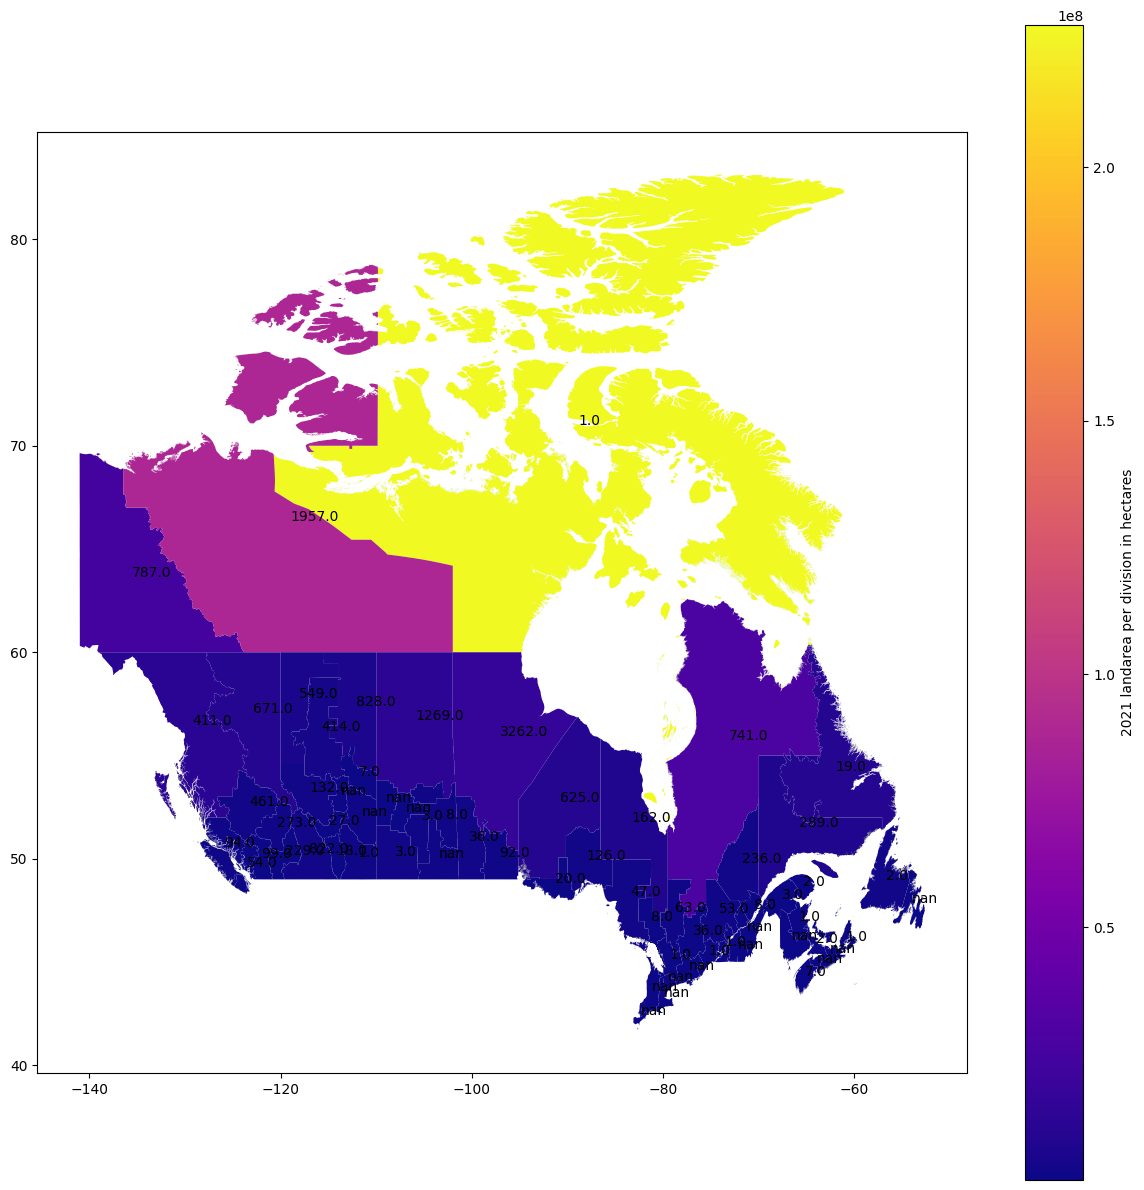

In [10]:
# plot the subdivsion map
ax = subdivion_df.fillna(0).plot(
    figsize=(15,15),
    column = "area",
    cmap='plasma',
    legend = True,
    legend_kwds={"label": "2021 landarea per division in hectares", "orientation": "vertical"}
)

# print cluster id on the cluster in figure
for x, y, label in zip(subdivion_df.centroid.x, subdivion_df.centroid.y, subdivion_df['count']):
    ax.annotate(label, xy=(x, y), xytext=(0, 0), textcoords="offset points", color='k')

In [11]:
# Store the grouped cluster info into 'new_cluster_ids'
new_cluster_ids = {}

# drop Nunavut provvence
subdivion_df.drop([2], inplace=True, axis=0)

# merge Ontario divisions
ontario_cluster_1 = [11, 36, 41]
ontario_cluster_2 = [12, 21, 47, 54, 31, 48, 53, 40, 65, 42, 30, 46, 28]

# generating Ontario cluster info
ontario_geo_cluster_1 = subdivion_df[subdivion_df['div_id'].isin(ontario_cluster_1)]
ontario_geo_cluster_2 = subdivion_df[subdivion_df['div_id'].isin(ontario_cluster_2)]
ontario_cluster_geometry_1 = ontario_geo_cluster_1.geometry.unary_union
ontario_cluster_geometry_2 = ontario_geo_cluster_2.geometry.unary_union
ontario_cluster_id_1 = subdivion_df.index.max() + 1
ontario_cluster_id_2 = subdivion_df.index.max() + 2
ontario_clusetr_count_1 = ontario_geo_cluster_1['count'].sum()
ontario_clusetr_count_2 = ontario_geo_cluster_2['count'].sum()
ontario_clusetr_area_1 = ontario_geo_cluster_1['area'].sum()
ontario_clusetr_area_2 = ontario_geo_cluster_2['area'].sum()

# adding Ontario cluster
subdivion_df.loc[ontario_cluster_id_1] = [ontario_cluster_geometry_1, ontario_clusetr_count_1, ontario_cluster_id_1, ontario_clusetr_area_1]
subdivion_df.loc[ontario_cluster_id_2] = [ontario_cluster_geometry_2, ontario_clusetr_count_2, ontario_cluster_id_2, ontario_clusetr_area_2]

# deleting old Ontario clusters
subdivion_df.drop(ontario_cluster_1, inplace=True, axis=0)
subdivion_df.drop(ontario_cluster_2, inplace=True, axis=0)

# add cluster info 
new_cluster_ids[ontario_cluster_id_1] = ontario_cluster_1
new_cluster_ids[ontario_cluster_id_2] = ontario_cluster_2

# del local variables
del ontario_cluster_1
del ontario_cluster_2
del ontario_geo_cluster_1
del ontario_geo_cluster_2
del ontario_cluster_geometry_1
del ontario_cluster_geometry_2
del ontario_cluster_id_1
del ontario_cluster_id_2
del ontario_clusetr_count_1
del ontario_clusetr_count_2

# merge Quebec, Nova Scotia, Newfoundland divisions
q_clusters = [1, 10, 13, 19, 20, 22, 35, 56, 60]
# generating Quebec, Nova Scotia, Newfoundland cluster info
q_geo_cluster = subdivion_df[subdivion_df['div_id'].isin(q_clusters)]
q_cluster_geometry = q_geo_cluster.geometry.unary_union
q_cluster_id = subdivion_df.index.max() + 1
q_clusetr_count = q_geo_cluster['count'].sum()
q_cluster_area = q_geo_cluster['area'].sum()
# adding Quebec, Nova Scotia, Newfoundland cluster
subdivion_df.loc[q_cluster_id] = [q_cluster_geometry, q_clusetr_count, q_cluster_id, q_cluster_area]
# deleting old Quebec, Nova Scotia, Newfoundland clusters
subdivion_df.drop(q_clusters, inplace=True, axis=0)
# add cluster info 
new_cluster_ids[q_cluster_id] = q_clusters
# del local variables
del q_clusters
del q_geo_cluster
del q_cluster_geometry
del q_cluster_id
del q_clusetr_count

# merge Manitoba divisions
m_clusters = [17, 52, 26]
# generating Manitoba cluster info
m_geo_cluster = subdivion_df[subdivion_df['div_id'].isin(m_clusters)]
m_cluster_geometry = m_geo_cluster.geometry.unary_union
m_cluster_id = subdivion_df.index.max() + 1
m_clusetr_count = m_geo_cluster['count'].sum()
m_clusetr_area = m_geo_cluster['area'].sum()
# adding Manitoba cluster
subdivion_df.loc[m_cluster_id] = [m_cluster_geometry, m_clusetr_count, m_cluster_id, m_clusetr_area]
# deleting old Manitoba clusters
subdivion_df.drop(m_clusters, inplace=True, axis=0)
# add cluster info 
new_cluster_ids[m_cluster_id] = m_clusters
# del local variables
del m_clusters
del m_geo_cluster
del m_cluster_geometry
del m_cluster_id
del m_clusetr_count

# merge BC divisions
bc_clusters = [8, 34, 45, 62, 64]
# generating BC cluster info
bc_geo_cluster = subdivion_df[subdivion_df['div_id'].isin(bc_clusters)]
bc_cluster_geometry = bc_geo_cluster.geometry.unary_union
bc_cluster_id = subdivion_df.index.max() + 1
bc_clusetr_count = bc_geo_cluster['count'].sum()
bc_clusetr_area = bc_geo_cluster['area'].sum()
# adding BC cluster
subdivion_df.loc[bc_cluster_id] = [bc_cluster_geometry, bc_clusetr_count, bc_cluster_id, bc_clusetr_area]
# deleting old BC clusters
subdivion_df.drop(bc_clusters, inplace=True, axis=0)
# add cluster info 
new_cluster_ids[bc_cluster_id] = bc_clusters
# del local variables
del bc_clusters
del bc_geo_cluster
del bc_cluster_geometry
del bc_cluster_id
del bc_clusetr_count

# merge alberta divisions
alberta_clusters = [4, 24, 44, 50, 59, 63, 66]
# generating alberta cluster info
alberta_geo_cluster = subdivion_df[subdivion_df['div_id'].isin(alberta_clusters)]
alberta_cluster_geometry = alberta_geo_cluster.geometry.unary_union
alberta_cluster_id = subdivion_df.index.max() + 1
alberta_clusetr_count = alberta_geo_cluster['count'].sum()
alberta_clusetr_area = alberta_geo_cluster['area'].sum()
# adding alberta cluster
subdivion_df.loc[alberta_cluster_id] = [alberta_cluster_geometry, alberta_clusetr_count, alberta_cluster_id, alberta_clusetr_area]
# deleting old alberta clusters
subdivion_df.drop(alberta_clusters, inplace=True, axis=0)
# add cluster info 
new_cluster_ids[alberta_cluster_id] = alberta_clusters
# del local variables
del alberta_clusters
del alberta_geo_cluster
del alberta_cluster_geometry
del alberta_cluster_id
del alberta_clusetr_count

# merge saskatchewan divisions
saskatchewan_cluster = [ 32,]
# generating saskatchewan cluster info
saskatchewan_geo_cluster = subdivion_df[subdivion_df['div_id'].isin(saskatchewan_cluster)]
saskatchewan_cluster_geometry = saskatchewan_geo_cluster.geometry.unary_union
saskatchewan_cluster_id = subdivion_df.index.max() + 1
saskatchewan_clusetr_count = saskatchewan_geo_cluster['count'].sum()
saskatchewan_clusetr_area = saskatchewan_geo_cluster['area'].sum()
# adding saskatchewan cluster
subdivion_df.loc[saskatchewan_cluster_id] = [saskatchewan_cluster_geometry, saskatchewan_clusetr_count, saskatchewan_cluster_id, saskatchewan_clusetr_area]
# deleting old saskatchewan clusters
subdivion_df.drop(saskatchewan_cluster, inplace=True, axis=0)
# add cluster info 
new_cluster_ids[saskatchewan_cluster_id] = saskatchewan_cluster
# del local variables
del saskatchewan_cluster
del saskatchewan_geo_cluster
del saskatchewan_cluster_geometry
del saskatchewan_cluster_id
del saskatchewan_clusetr_count


# setting crs
subdivion_df = subdivion_df.set_crs(epsg = "4326", inplace = True)

# drop remaining clusters 
subdivion_df = subdivion_df.dropna()

/tmp/ipykernel_206822/921050978.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(subdivion_df.centroid.x, subdivion_df.centroid.y, subdivion_df['count']):


Text(154.59722222222223, 0.5, 'Latitude')

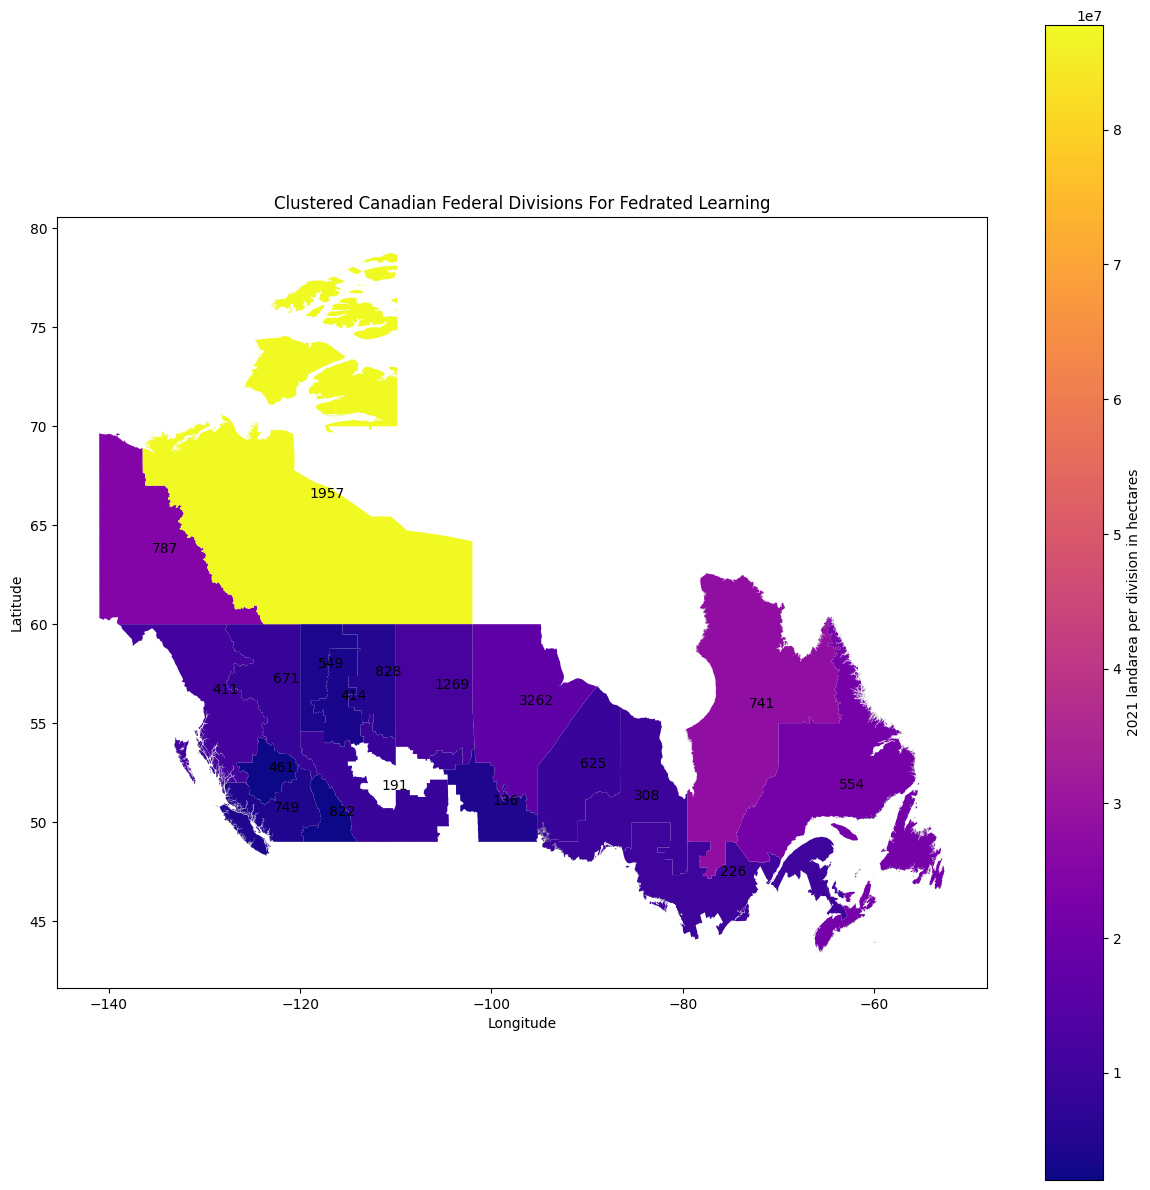

In [15]:
# plot the subdivsion map
ax = subdivion_df.plot(
    figsize=(15,15),
    column = "area",
    cmap='plasma',
    legend = True,
    legend_kwds={"label": "2021 landarea per division in hectares", "orientation": "vertical"}
)
# print fire record count
for x, y, label in zip(subdivion_df.centroid.x, subdivion_df.centroid.y, subdivion_df['count']):
    ax.annotate(f"{label:.0f}", xy=(x, y), xytext=(0, 0), textcoords="offset points", color='k')

ax.set_title("Clustered Canadian Federal Divisions For Fedrated Learning")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

In [13]:
subdivion_df.shape

(19, 4)

In [19]:
subdivion_df = subdivion_df[['geometry']]

This will override the previouslu existing subdivision table to the current one.

In [20]:
subdivion_df.to_postgis(
    name=SUBDIVISION_TABLE_NAME, 
    con=engine, 
    if_exists='replace', 
    index=True
)  

In [21]:
with engine.connect() as con:
    con.execute(f'ALTER TABLE "{SUBDIVISION_TABLE_NAME}" ADD PRIMARY KEY ("cid");')